### Exploration of Yelp Dataset, to find a features, we want to use in our model, and secondly to get a grasp of the data

In [29]:
import os
import sys
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Add correct path to python path
CUR_DIR = Path(os.getcwd())
sys.path.append(str(CUR_DIR.parent))
SAMPLE_FRACTION = 1.0
data_root =  CUR_DIR / ".." / "artifacts"


# Turn off warnings, because of output
import warnings
warnings.filterwarnings('ignore');

In [11]:
# start spark in local mode using 32gb of memory
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("name") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .getOrCreate();


In [30]:
users_df = spark.read.json(str(data_root / "data" / "yelp_academic_dataset_user.json"))
reviews_df = spark.read.json(str(data_root / "data" / "yelp_academic_dataset_review.json"));
reviews_df = reviews_df.withColumnRenamed("useful", "useful_votes")

In [32]:
# Subsample to get reasonable runtimes
from etl.etl.filter import sample_reviews
reviews_small_df = sample_reviews(reviews_df, SAMPLE_FRACTION).cache();

23/06/06 14:54:39 WARN CacheManager: Asked to cache already cached data.


In [33]:
def create_histogram(df, column, bins=20):
    bins, vals = df.select(column).rdd.flatMap(lambda x: x).histogram(bins)
    # Floor the values of the bins
    bins = [int(b) for b in bins]
    return pd.DataFrame(list(zip(bins, vals)), columns=['count', 'frequency']);

### First let's get the feeling for the data

Random Sample of 5 reviews

In [34]:
reviews_small_df.limit(5).toPandas()

,business_id,cool,date,funny,review_id,stars,text,useful_votes,user_id
0,LHSTtnW3YHCeUkRDGyJOyw,0,2015-08-07 02:29:16,0,_ZeMknuYdlQcUqng_Im3yg,5.0,Amazingly amazing wings and homemade bleu chee...,2,yfFzsLmaWF2d4Sr0UNbBgg
1,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw
2,CLEWowfkj-wKYJlQDqT1aw,1,2016-03-07 00:02:18,0,u2vzZaOqJ2feRshaaF1doQ,5.0,I go to blow bar to get my brows done by natal...,2,NDZvyYHTUWWu-kqgQzzDGQ
3,SSZDGl2J-CEyIzuIbEiYNQ,0,2017-09-08 23:20:19,0,yCbzm_d4cHpfUX00Ljvgmg,2.0,"We started with the artichoke dip, big mistake...",2,bHSoye7R5cL-LVWLxtaxMg
4,6LCZLGa09Qifn6rG7-DNrg,1,2015-02-16 07:20:16,0,dzNxNW9XpJiECE-bKATezw,4.0,My go to menu is coconut soup and pad thai wit...,0,NUtIAX-ygn474tDg5nmesg


Useful summary statistics.

In [47]:
reviews_small_df.select('useful_votes').summary().toPandas()

,summary,useful_votes
0,count,698757
1,mean,1.1907887863735176
2,stddev,3.430496792093755
3,min,-1
4,25%,0
5,50%,0
6,75%,1
7,max,865


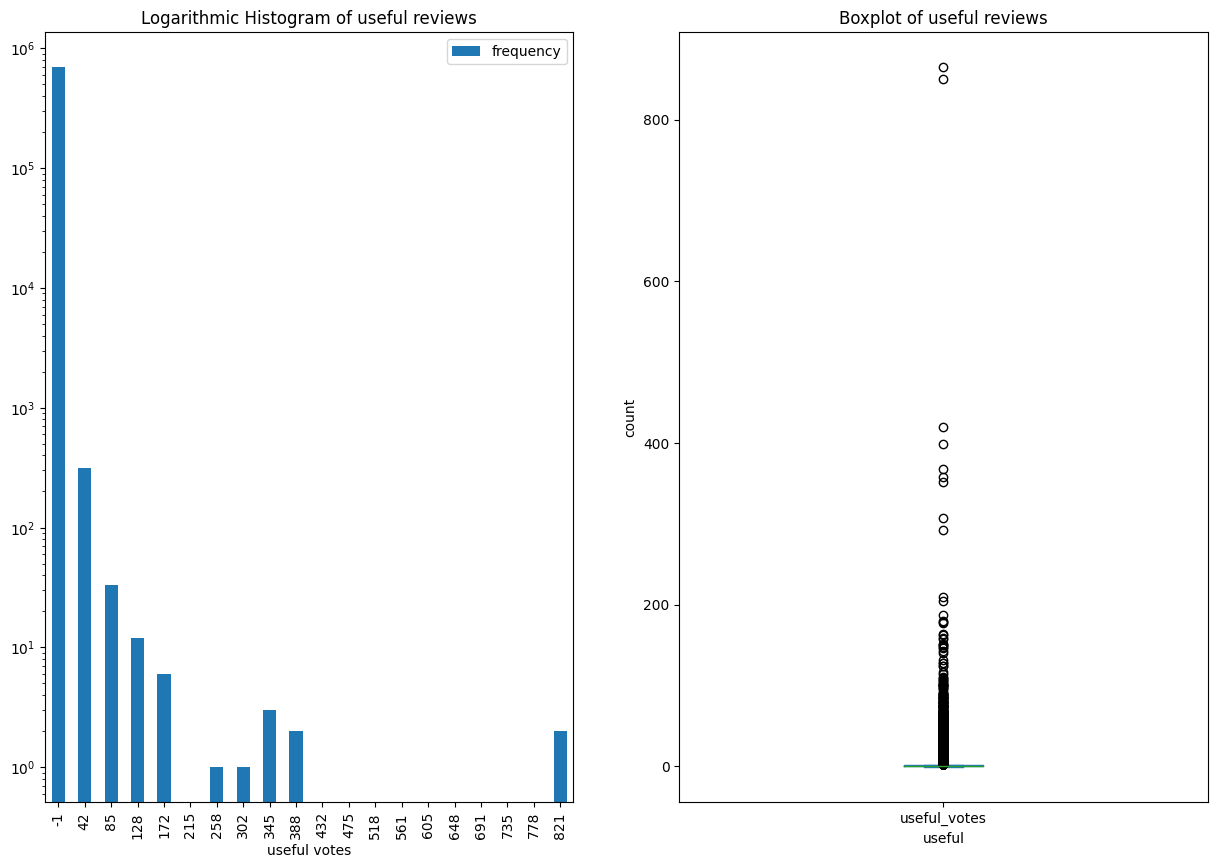

In [71]:
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
create_histogram(reviews_small_df, "useful_votes").plot(x="count", y="frequency", kind="bar", logy=True, title="Logarithmic Histogram of useful reviews", ax=ax1, xlabel="useful votes")
reviews_small_df.select("useful_votes").toPandas().plot(kind="box", ax=ax2, title="Boxplot of useful reviews", xlabel="useful", ylabel="count")
plt.show()

As we can see it very skewed, the 50% quantile is 0, suggesting that most of the reviews didn't get a single useful vote. That is really a problem, as the algorithm would they simple predict 0 for most of the reviews and still get good MSE. The question is whether the review with 100 votes is really 100 times more useful than the one with 1 vote. We will thus categorize the usefulness into 3 categories: 0, 
1-5, 5+.

<AxesSubplot: title={'center': 'Useful vs not useful reviews'}, xlabel='usefulness'>

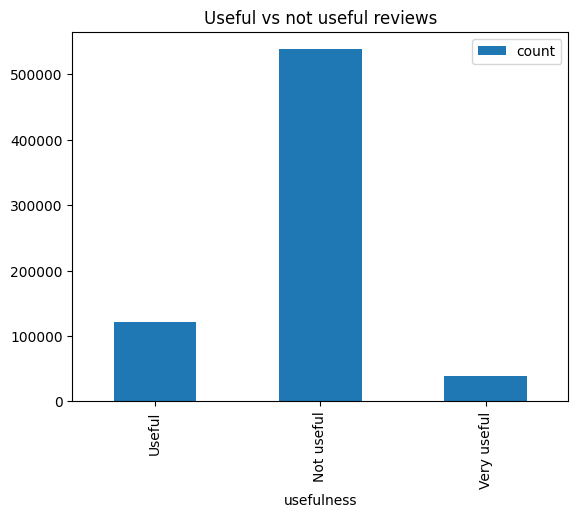

In [68]:
from etl.etl.transform import categorize_usefulness
# It looks like we can simply use > 1 as useful and > 5 as very useful

reviews_with_useful_df = categorize_usefulness(reviews_small_df)
reviews_with_useful_df.groupBy("usefulness").count().toPandas().plot(kind="bar", x="usefulness", y="count", title="Useful vs not useful reviews")
plt.show()

# It's still very imbalanced, but we can deal with it


Now when we know what we are going to predict, let's look at the features.

We will start with looking at language of reviews

In [70]:
from ftlangdetect import detect
# We will mostly work with text, so let's see what language the reviews are in

# I have to RY this twice, because worker will not have the etl package in disposal..., so the udf will fail
def detect_all_lines_lang(text):
    return detect(" ".join(text.split("\n")))["lang"]


reviews_small_df_with_lang = reviews_small_df.withColumn("language", F.udf(detect_all_lines_lang)(F.col("text")))
by_lang = reviews_small_df_with_lang.groupBy("language").count().orderBy(F.desc("count"));

# Most of the reviews are in english, so so we cant drop the other, without really losing much data

,language,count
0,en,698226
1,es,253
2,de,85
3,fr,59
4,zh,36
5,pt,25
6,it,20
7,ja,16
8,sv,8
9,nl,7


In [72]:
by_lang.toPandas()


,language,count
0,en,698226
1,es,253
2,de,85
3,fr,59
4,zh,36
5,pt,25
6,it,20
7,ja,16
8,sv,8
9,nl,7


Most of the reviews are in English, which is good, as we don't have to deal with multiple languages. We will thus use only English reviews.

Let's now look at text of the reviews

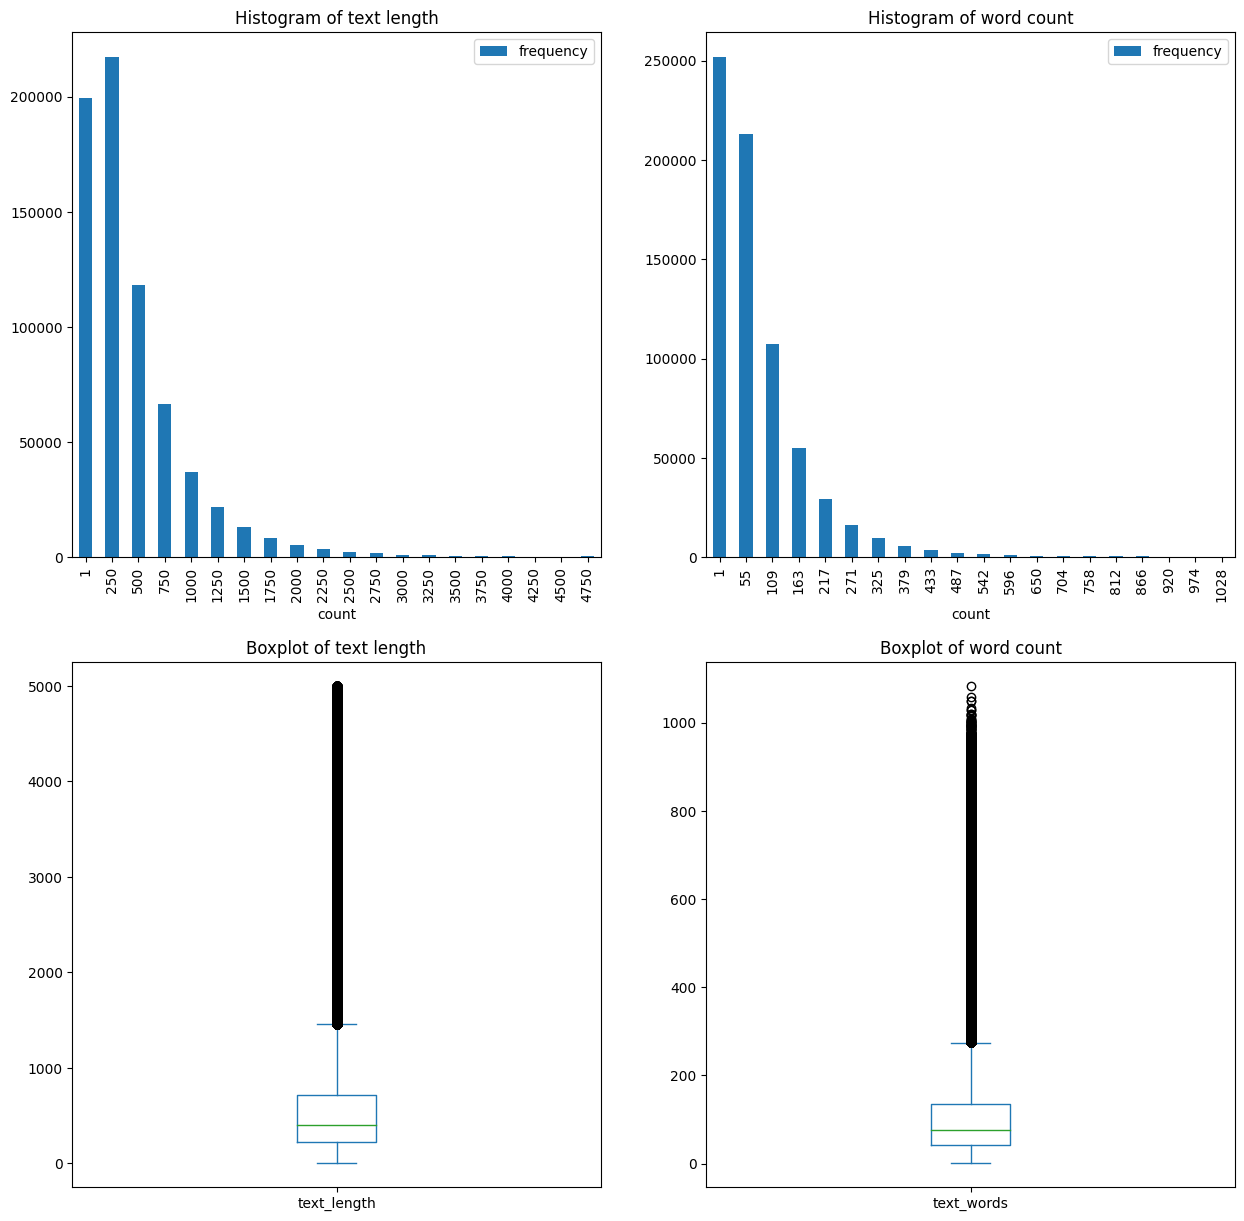

In [98]:
from etl.etl.transform import add_text_properties
# We can see more thing let's observe distribution of length of reviews

with_text_properties = add_text_properties(reviews_with_useful_df).cache()
fig = plt.figure(figsize=(15, 15))
fig.tight_layout()
(ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)
create_histogram(with_text_properties, "text_length").plot(x="count", y="frequency", kind="bar", title="Histogram of text length", ax=ax1)
create_histogram(with_text_properties, "text_words").plot(x="count", y="frequency", kind="bar", title="Histogram of word count", ax=ax2)
with_text_properties.select("text_length").toPandas().plot(kind="box", ax=ax3, title="Boxplot of text length")
with_text_properties.select("text_words").toPandas().plot(kind="box", ax=ax4, title="Boxplot of word count")
plt.show()


In [93]:
from pyspark.sql.types import LongType, DoubleType, IntegerType, FloatType
def get_numeric_fields(df):
    return [col for col in df.schema.fields if isinstance(col.dataType, DoubleType) or isinstance(col.dataType, LongType) or isinstance(col.dataType, IntegerType) or isinstance(col.dataType, FloatType)]

def get_numeric_correlation_df(df, target):
    corr = {}
    for col in get_numeric_fields(df):
        corr[col.name] = df.corr(col.name, target)
    return pd.DataFrame.from_dict(corr, orient="index", columns=["correlation"]);

Most of the reviews are rather short, but that's not a reason to discard them.
It migh be possible that they are not as informative as longer ones, let' see.

In [96]:
# Let's observe if there is correlation between the above and the target variable
get_numeric_correlation_df(with_text_properties, "useful_votes").sort_values(by="correlation", ascending=False)

,correlation
useful_votes,1.000000
cool,0.696743
funny,0.481529
text_length,0.233515
text_words,0.228899
stars,-0.068455


There is correlation, but not that significant. The other votable features (cool, funny) are very corelates, but they will note be available.

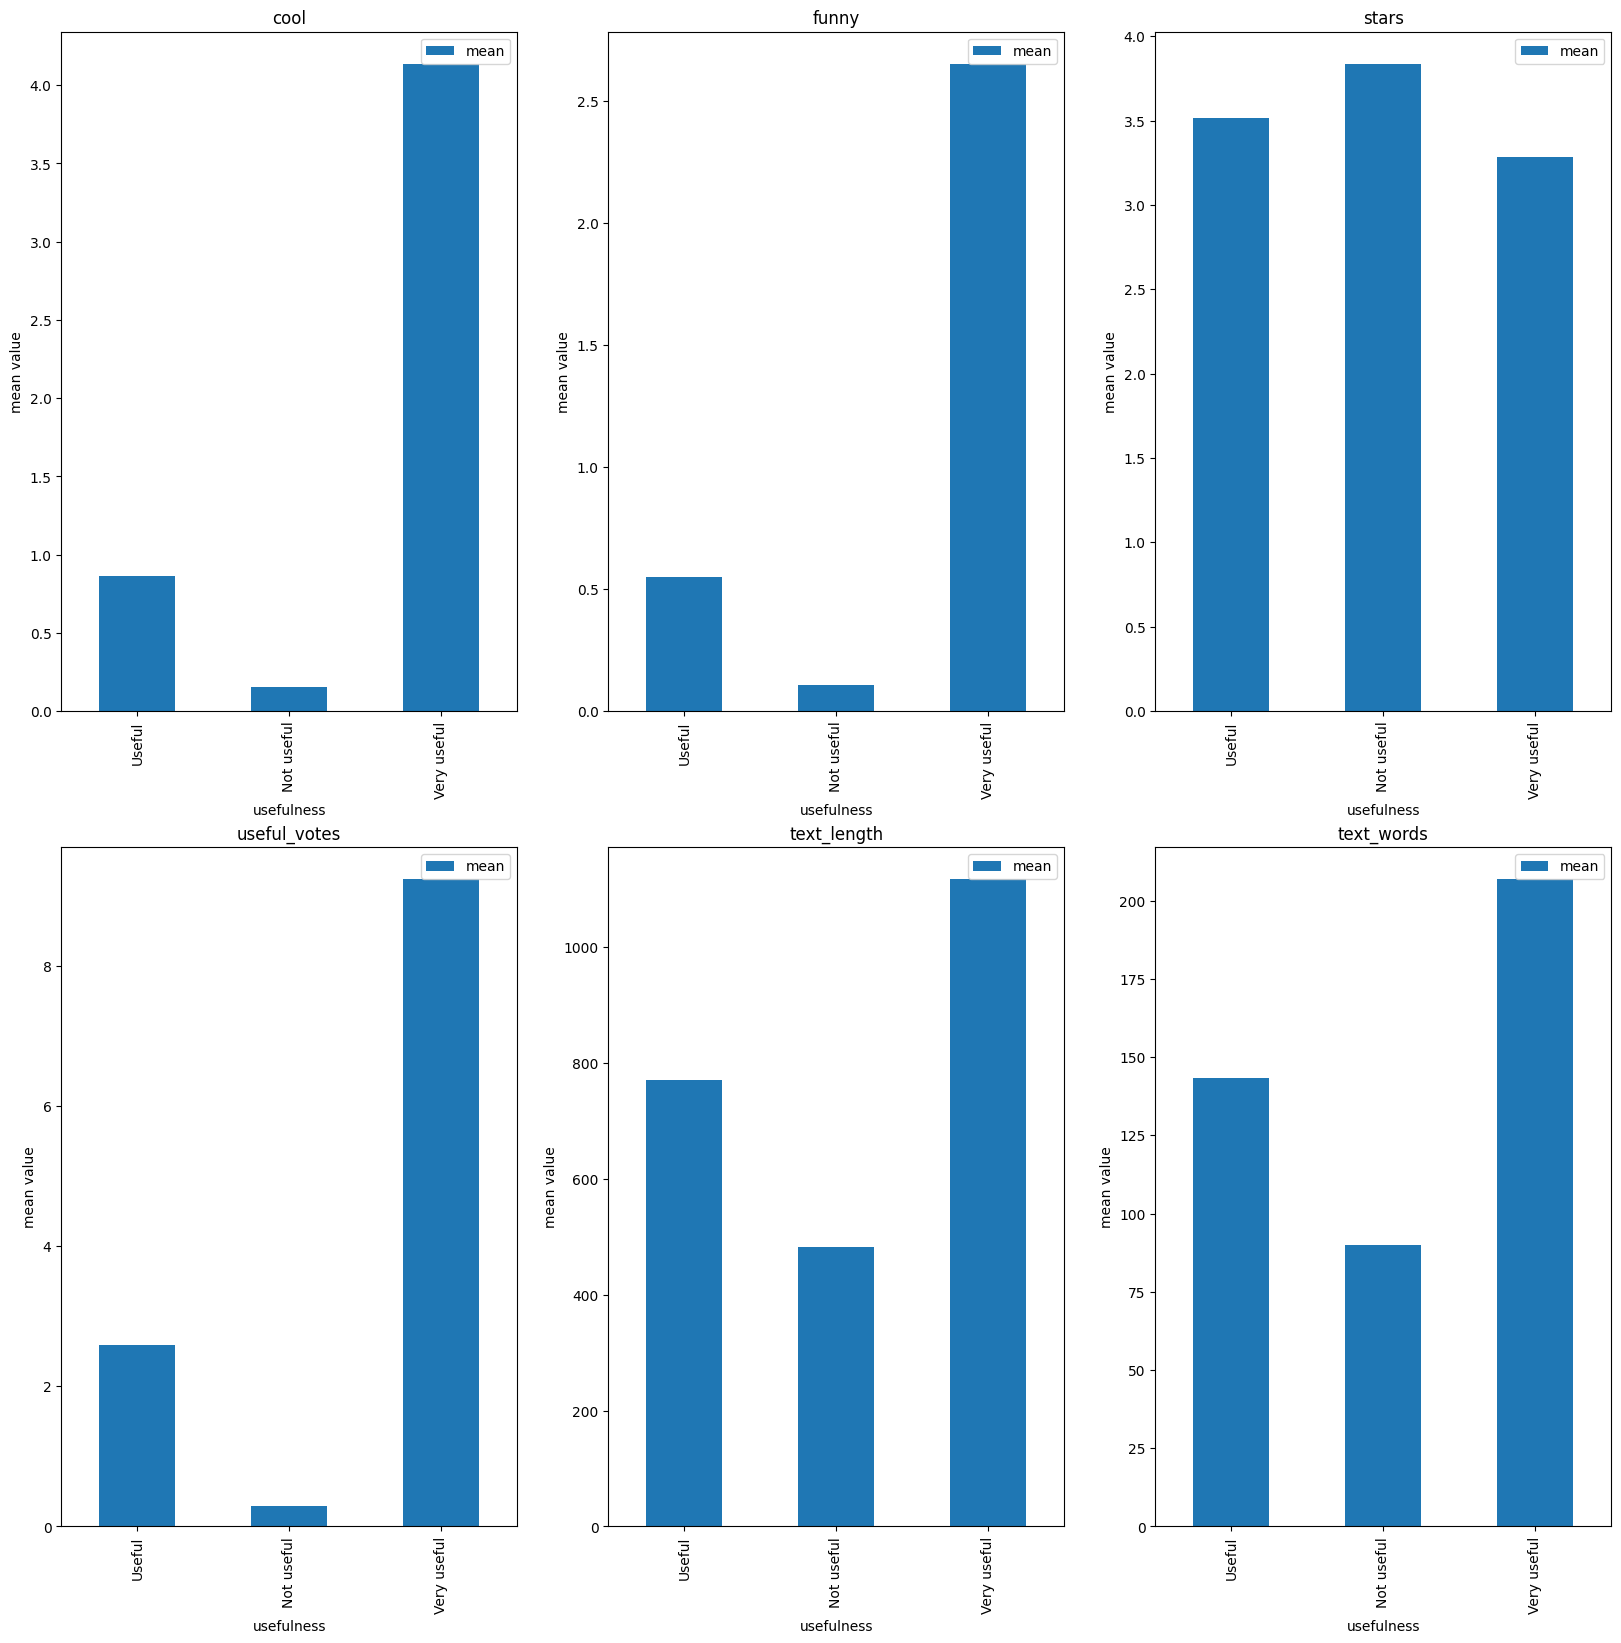

In [103]:
# create a bar plot for each numeric column, show how in what useful category it is

fig = plt.figure(figsize=(20, 30))
fig.tight_layout()
for i, col in enumerate(get_numeric_fields(with_text_properties)):
    ax = fig.add_subplot(3, 3, i + 1)
    with_text_properties.groupBy("usefulness").agg(F.mean(col.name).alias("mean")).toPandas().plot(kind="bar", x="usefulness", y="mean", ax=ax, title=col.name, xlabel="usefulness", ylabel="mean value")
plt.show()

As we can see from corelations and means values, the stars really don't matter when it comes to usefulness. It's not that surprising, as the usefulness is not a rating, but rather a measure of how much people found the review helpful. While 0 correlation might suggest that feature is not useful, it's not really true in non-linear models. We will thus keep it.

We will now move onto users and their properties

In [104]:
with_text_properties.unpersist()
# Enough with reviews, let's look at users who submit them
# We will again subsample to get reasonable runtimes

users_df_small = users_df.sample(0.1).cache();

Let's get feeling for the data

In [105]:
# Show first 5 and convert to pandas
users_df_small.limit(5).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.27,26,6,26,24,2,4,12,9,16,...,299,"2009,2010,2011",28,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",330,Gwen,224,512,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33
1,3.85,2543,361,2543,1713,147,163,1212,323,5696,...,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014",1357,"xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",9940,Jane,1221,14953,q_QQ5kBBwlCcbL1s4NVK3g,2005-03-14 20:26:35
2,2.75,0,0,0,0,0,0,0,0,1,...,0,,1,"HDAQ74AEznP-YsMk1B14CA, 6A6-aIX7fg_zRy9MiE6YyQ...",1,Rob,12,6,cxuxXkcihfCbqt5Byrup8Q,2009-02-24 03:09:06
3,3.75,221,22,221,212,34,17,67,17,158,...,1297,"2007,2008,2009,2010,2011",44,"j3MBGSLaXMlhLZNeALWMJg, IMwY936vx7sL5RZSm1yQ4g...",1138,Eugene,682,1819,SgiBkhXeqIKl1PlFpZOycQ,2006-08-25 16:47:25
4,3.52,21,0,21,10,0,0,11,0,8,...,203,"2015,2016",5,"ElaFwOTdEpkiYPkHMpOwXQ, nbnftigv3fj8oS6k-waLYQ...",141,Stephanie,201,555,FT9CFS39sjZxVjCTrDHmdg,2010-06-14 21:44:28


In [106]:
users_df_small.summary().toPandas()

,summary,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,count,197835,197835,197835,197835,197835,197835,197835,197835,197835,...,197835,197835,197835,197835,197835,197835,197835,197835,197835,197835
1,mean,3.630807996562784,2.6968382743195085,0.1364369297647029,2.6968382743195085,1.7426188490408674,0.056329769757626304,0.2812747997068264,1.361387014431218,1.03992215735335,...,23.840948264968283,2017.1771879483501,1.4663431647585108,None,16.79183663153638,NaN,23.258973386913336,42.321717592943614,None,None
2,stddev,1.1821382338437196,75.43293592440816,6.310659632292893,75.43293592440816,64.57054314586783,3.541378867106102,6.7612296204048,26.261305267034853,43.3542292567853,...,540.6887711213797,4.072497586855533,15.464478940762943,None,367.6319521737009,NaN,79.54494587091531,619.0894814614363,None,None
3,min,1.0,0,0,0,0,0,0,0,0,...,0,,0,"--0HJ6vVv3TXHPwjn_JL2g, TLNNcyF8X7vZ0HHZXqX9SQ...",0,'Cheri,0,0,---r61b7EpVPkb4UVme5tA,2004-10-12 08:46:43
4,25%,3.0,0,0,0,0,0,0,0,0,...,0,2015.0,0,None,0,NaN,2,0,None,None
5,50%,3.88,0,0,0,0,0,0,0,0,...,0,2018.0,0,None,0,NaN,5,3,None,None
6,75%,4.56,0,0,0,0,0,0,0,0,...,3,2021.0,0,None,2,NaN,17,13,None,None
7,max,5.0,13022,1480,13022,19373,1319,1804,3196,7336,...,113371,2021,2107,"zzuN91er1GcEoDdHO9qluQ, kAkXU-UAiwQviJLYRN-ULw...",96505,骏宇,8354,117066,zzzCg-_lpyYE82TlJCdwdw,2022-01-19 17:14:10


The compliment features are very skewed. Very few users actually have them non-zero.
Let's see their corelations between each other.

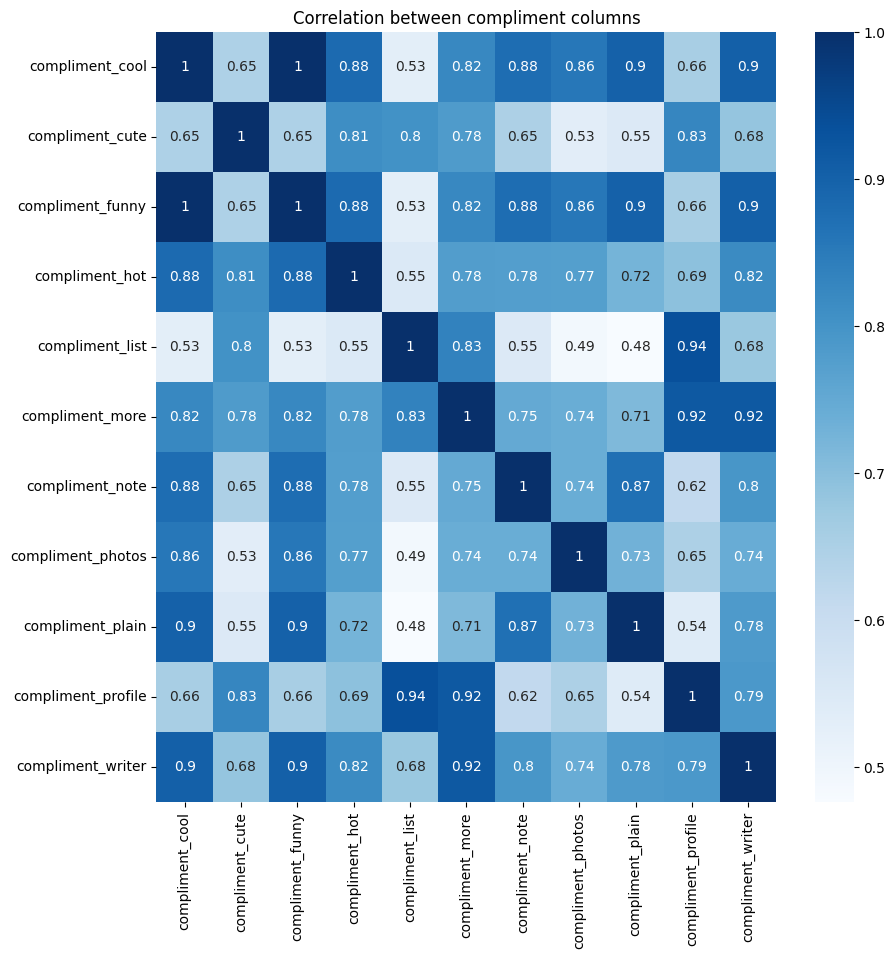

In [107]:
import seaborn as sns
# Those compliment look like they might be correlated between each other, let's check
compliment_cols = [col for col in users_df_small.columns if "compliment" in col]
# Sucks that we have to convert to pandas, but I don't know how to do it in pure spark with few lines
correlations = users_df_small.select(compliment_cols).toPandas().corr()

# plot
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(111)
sns.heatmap(correlations, annot=True, ax=ax, cmap="Blues")
ax.set_title("Correlation between compliment columns")
plt.show()

In [131]:
# Really high correlations accross the board, we can really just keep the cute, cool and list
users_df_small = users_df_small.drop(*[col for col in compliment_cols if col not in ["compliment_cute", "compliment_cool", "compliment_list"]]);

Interestingly there is high correlation between them. We will thus use only use
commplient_list, complient_cute and complient_cool.



Next we will calculate how long the user is on yelp since 1970. It might be that the longer the user is on yelp, the more useful his review is and we would not use the yelping_since feature otherwise

In [141]:
from etl.etl.transform import add_user_features, pre_transform
# Okay let's now join the two datasets and see if we can find some correlations
# Important to use the big users df, with the small df columns, otherwise we will get a lot of nulls

reviews_users_df = pre_transform({"reviews": reviews_small_df, "users": users_df})

# Let's also add the user features
reviews_users_df = add_user_features(reviews_users_df).cache()

# And text features
reviews_users_df = add_text_properties(reviews_users_df).cache();

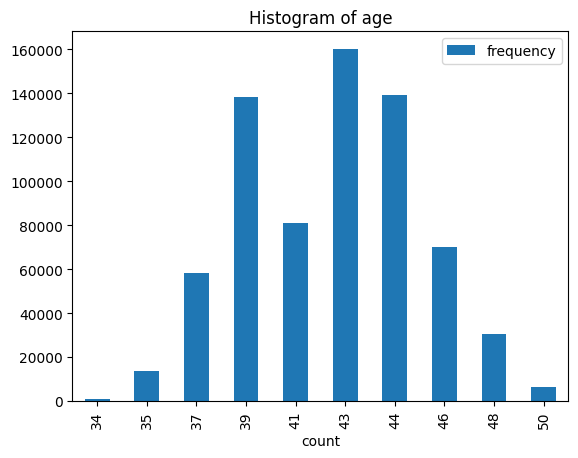

In [142]:
# Show histogram of age

create_histogram(reviews_users_df, "user_age", bins=10).plot(x="count", y="frequency", kind="bar", title="Histogram of age")
plt.show()

Most of the users are from 2013, showing the decreasing popularity of yelp.

Lastly we will not take all features we got and see how they correlate with the usefulness

In [143]:
# Let's observe the corelations between user numeric columns and useful
correlations = get_numeric_correlation_df(reviews_users_df, "useful_votes").sort_values(by="correlation", ascending=False)
plt.show()

Scatter plots of top 4 of them based on absolute correlation

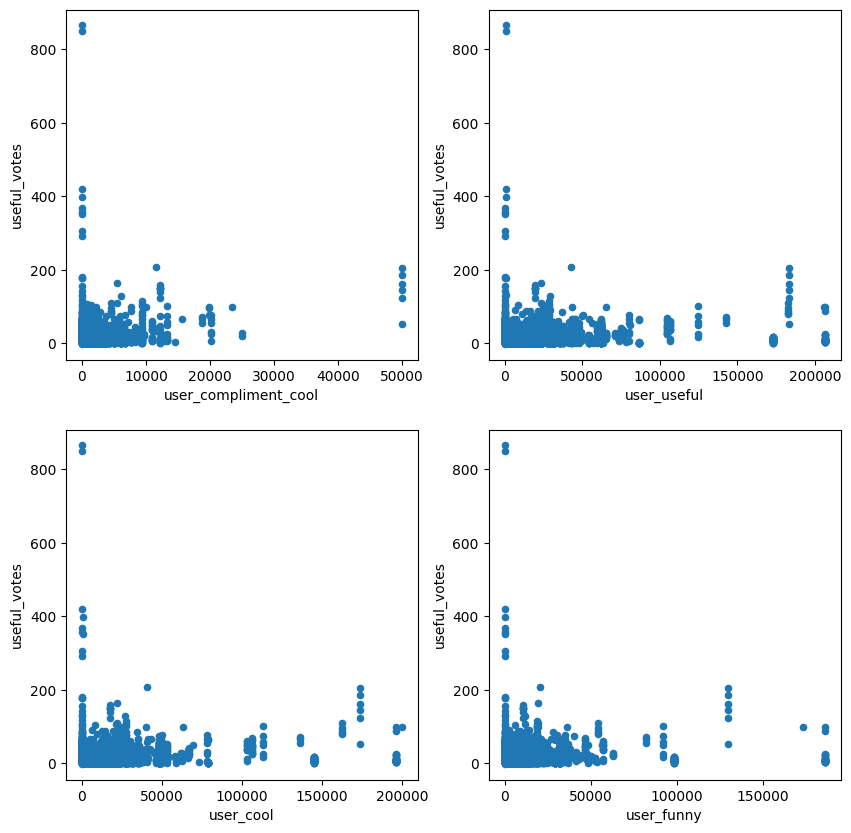

In [144]:
# Let's observe the correlation as plots

# Take top 4 correlations in absolute value
top_corrs = correlations.iloc[1:5].iterrows()
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
for i, (col, corr) in enumerate(top_corrs):
    ax = fig.add_subplot(2, 2, i + 1)
    # Create a scatter plot between the column and useful
    reviews_users_df.select(col, "useful_votes").toPandas().plot(kind="scatter", x=col, y="useful_votes", ax=ax)

plt.show()

As can be seen all of them are user properties.

Finally let's see how many missing values we have in our features

In [147]:
# Lastly let's observe the # null values for each column
null_values = reviews_users_df.select([F.count(F.when(F.isnan(c.name) | F.col(c.name).isNull(), c.name)).alias(c.name) for c in get_numeric_fields(reviews_users_df)]).toPandas()
null_values

,stars,useful_votes,user_review_count,user_useful,user_funny,user_cool,user_fans,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_list,user_age,text_length,text_words
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
reviews_users_df.filter(F.isnan("user_age") | F.col("user_age").isNull()).limit(5).toPandas()

,user_id,stars,useful_votes,text,date,user_review_count,user_useful,user_funny,user_cool,user_yelping_since,user_elite,user_fans,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_list,user_age,text_length,text_words


Some are missing but nothing too serious.